In [402]:
import numpy as np
import matplotlib.pyplot as plt

G = 6.67e-11 
re_real = 6371e3
re = 2 * re_real
me = 5.972e24
# t = 112654  # thickness of earth
# t = 10
t = re / 20
def calc_y(r_total, r, m_total):
    y = 2 * np.sqrt(r_total**2 - r**2)
    return y
    
def unit(v):
    return v / np.linalg.norm(v, axis=0)

def make_linear_mesh(r_total, m_total, t, size, debug=False):
    v_total = np.pi * r_total**2 * t
    bounds = np.linspace(-r_total, r_total, int(2*r_total // size))
    sizes = np.diff(bounds)
    locs = bounds[:-1] + (sizes / 2)
    
    vs = calc_y(r_total, locs, m_total) * sizes * t
    ms = vs / v_total * m_total
    
    mass_locs = np.vstack((locs, np.ones_like(locs) * -t/2))
    
    if debug:
        v_error = abs(np.sum(vs) - v_total) / v_total * 100
        m_error = abs(np.sum(ms) - m_total) / m_total * 100
        print("Mesh volume is {:.2e}".format(v_error), " % off")
        print("Mesh mass is {:.2e}".format(v_error), " % off")
    return ms, mass_locs

def calc_grav(pos, m, ms, mass_locs, debug=False):
    rs = mass_locs - pos

    r_mags = np.linalg.norm(rs, axis=0)
    Fs = ms * m * G * unit(rs) / r_mags**1
    
    
    

    F_grav = np.sum(ms * m * G * unit(rs) / r_mags**2, axis=1)
    if debug:
        print(mass_locs[0, :].shape, rs[0,:].shape)
        plt.quiver(mass_locs[0, :], mass_locs[1, :], Fs[0, :], Fs[1,:], units='xy')
        plt.plot(pos[0], pos[1] - t/2, 'r*')
        
        plt.xlim([-re, re])
#         plt.axis('equal')
        plt.quiver(pos[0], pos[1]-t/2, F_grav[0], F_grav[1], color='b')
    return F_grav

Mesh volume is 7.62e-06  % off
Mesh mass is 7.62e-06  % off
(25483,) (25483,)
[  -6.99364891 -107.96838372]


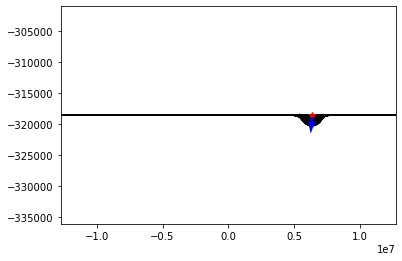

In [403]:
ms, locs = make_linear_mesh(re, me, t, 1000, 1)
pos = np.array([re*0.5, 0]).reshape(2,1)

m = 1

# pos = np.array([0, re * 0.5]).reshape(2,1)
F_grav = calc_grav(pos, m, ms, locs, 1)

print(F_grav)


    

In [404]:
num_x = 100
num_y = 10
xs = np.linspace(0, 1.1*re, num_x)
ts = np.zeros_like(xs)
mags = np.zeros_like(xs)
fs = np.zeros([2, len(xs)])
for i, x in enumerate(xs):
    pos = np.array([x, 0*re]).reshape(2,1)
    f = calc_grav(pos, m, ms, locs)
    ts[i] = -np.arctan2(f[1], f[0])* 180 / np.pi -90
    mags[i] = np.linalg.norm(f)
    fs[:,i] = f

84.76621021401203


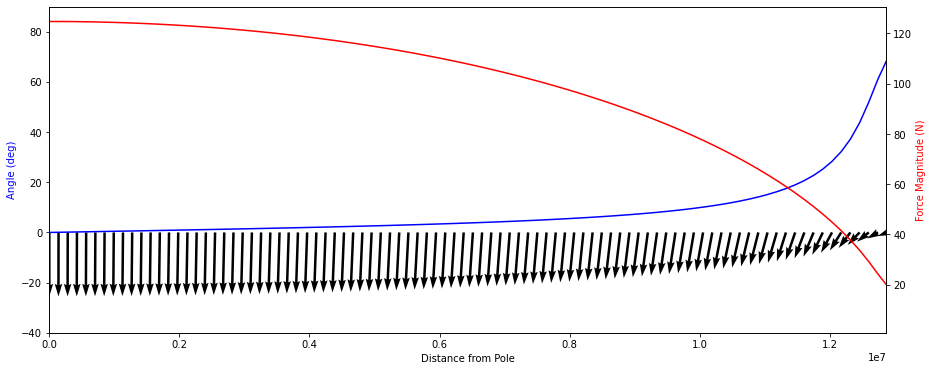

In [405]:
fig, ax1 = plt.subplots()

ax1.plot(xs, ts, 'b-')
ax1.set_xlabel('Distance from Pole')
ax1.set_ylabel('Angle (deg)', color='b')
ax1.quiver(xs, np.zeros_like(xs), fs[0, :], fs[1, :], width=0.003)
ax2 = ax1.twinx()
ax2.set_ylabel('Force Magnitude (N)', color='r')
ax2.plot(xs, mags, 'r-')
print(max(ts))
ax1.set_xlim([0, re*1.01])
ax1.set_ylim([-40, 90])
fig.set_size_inches(15, 6)

In [316]:
b = np.arange(5)
b = np.vstack([b,b])
print(b.shape, b)
a = np.array([1,3]).reshape(2,1)
print(a.shape, a)
print(b-a)

(2, 5) [[0 1 2 3 4]
 [0 1 2 3 4]]
(2, 1) [[1]
 [3]]
[[-1  0  1  2  3]
 [-3 -2 -1  0  1]]


In [387]:
fs = np.zeros([2, len(xs)])
print(fs[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [11]:
b = np.arange(5) * 2
np.diff(b)

array([2, 2, 2, 2])

In [12]:
b

array([0, 2, 4, 6, 8])

In [13]:
b[:-1]

array([0, 2, 4, 6])